### Preamble

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.cluster.vq import kmeans
from utils.plotting import *
from gpflow.config import default_float, default_jitter
from gpflow_sampling.samplers import decoupled

In [2]:
%matplotlib inline
set_default_rcParams(plt, fontsize=12, usetex=True)

In [3]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

###  Generate ground truth data

In [4]:
ground = gpflow.models.GPR(data=(np.zeros([0, 1]), np.zeros([0, 1])),  # replaced below
                        kernel=gpflow.kernels.Matern52(lengthscales=0.1, variance=1.0),
                        mean_function=lambda X_data: 0.0,
                        noise_variance=1e-2)

gpflow.utilities.set_trainable(ground, False)

In [5]:
X = tf.random.uniform(shape=[6, 1], dtype=default_float())
Knn = ground.kernel(X, full_cov=True)
Snn = tf.linalg.set_diag(Knn, tf.linalg.diag_part(Knn) + ground.likelihood.variance)
Lnn = tf.linalg.cholesky(Snn)
y = tf.matmul(Lnn, tf.random.normal([len(X), 1], dtype=X.dtype))

ground.data = (X, y)

### Initialize decoupled SVGP

In [6]:
class DecoupledSVGP(gpflow.models.SVGP):
    def __init__(self, *args, num_samples: int, num_basis: int, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_samples = num_samples  # num. samples used to estimate posterior
        self.num_basis = num_basis  # num. RFF used to approximate prior
        self._sampler = None

    def elbo(self, data: tuple) -> tf.Tensor:
        """
        Estimate the evidence lower bound on the log marginal
        likelihood of the model by using decoupled sampling
        to construct a Monte Carlo integral.
        """
        X, Y = data
        kl = self.prior_kl()
        
        # Recompute terms and resample random variables both 
        # because the model may have changed and to avoid 
        # persistent sample bias.
        self.sampler.reset_random_variables()
        monte_carlo = tf.reduce_mean(  # estimated variational expectation
                            self.likelihood.log_prob(self.sampler(X), Y),
                            axis=0)
                
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)
        return tf.reduce_sum(monte_carlo) * scale - kl
    
    @property
    def sampler(self) -> decoupled:
        # Use persistent sampler to avoid repeatedly creating <tf.Variable>
        if self._sampler is None:  
            self._sampler = decoupled(self,
                                      self.kernel,
                                      sample_shape=[self.num_samples],
                                      num_basis=self.num_basis)
        return self._sampler

In [7]:
model = DecoupledSVGP(kernel=ground.kernel,
                      mean_function=ground.mean_function,
                      likelihood=ground.likelihood,
                      inducing_variable=kmeans(X, k_or_guess=4)[0],
                      num_basis=1024,
                      num_samples=128)

### Train decoupled SVGP

In [8]:
closure = model.training_loss_closure(data=ground.data, compile=True)
optimizer = tf.keras.optimizers.Adam()
step_iterator = tqdm(range(5000))
for step in step_iterator:
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = closure()

    loss_ema = loss if (step == 0) else 0.9 * loss_ema + 0.1 * loss
    step_iterator.set_postfix({'EMA(loss)':f'{loss_ema:.3e}'})
    grads = tape.gradient(loss, model.trainable_variables)
    grads_and_vars = tuple(zip(grads, model.trainable_variables))
    optimizer.apply_gradients(grads_and_vars)    

### Visualize

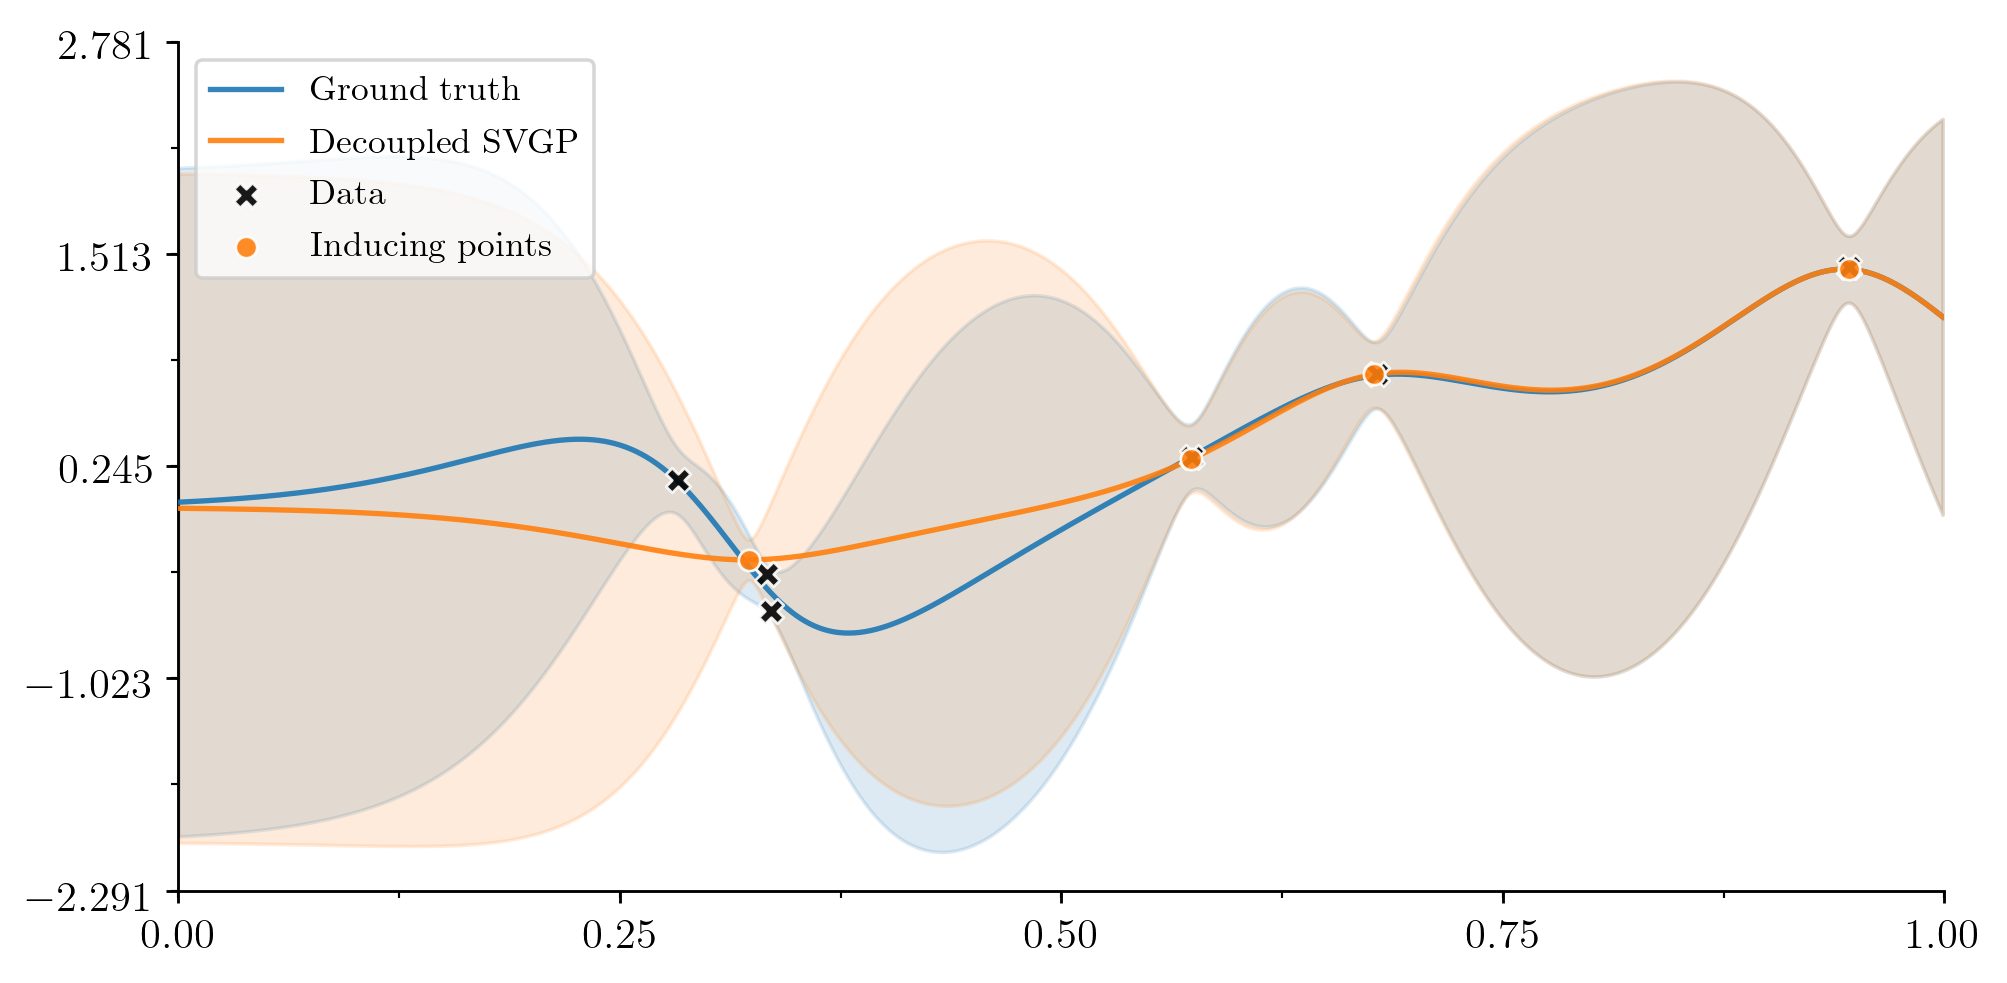

In [9]:
style = AttrDict()
style.data = ObjectStyle(color='k', marker='X', s=48, label='Data')
style.ground = ObjectStyle(color='tab:blue', label='Ground truth')
style.inducing = ObjectStyle(color='tab:orange', marker='o', label='Inducing points')
style.model = ObjectStyle(color='tab:orange', label='Decoupled SVGP')

# Compare posteriors
fig, ax = plt.subplots(figsize=(8, 4)) 
Xnew = tf.range(0, 1, 1e-3, dtype=default_float())[:, None]
with set_temporary_ax(ax):
    # Plot ground truth marginals
    mf, vf = list(map(tf.squeeze, ground.predict_f(Xnew)))
    sf = tf.sqrt(vf)
    plot_line(Xnew, mf, **style.ground)
    plot_fill(Xnew, mf - 2 * sf, mf + 2 * sf, **style.ground.omit('label'))
    
    # Plot decoupled SVGP marginals
    mf, vf = list(map(tf.squeeze, model.predict_f(Xnew)))
    sf = tf.sqrt(vf)
    plot_line(Xnew, mf, **style.model)
    plot_fill(Xnew, mf - 2 * sf, mf + 2 * sf, **style.model.omit('label'))
    
    # Plot training data and inducing locations
    plot_scatter(*ground.data, **style.data)
    Z = model.inducing_variable
    q_mu = model.q_mu.numpy()
    if model.whiten:
        Kuu = gpflow.covariances.Kuu(Z, model.kernel, jitter=default_jitter())
        q_mu = tf.linalg.cholesky(Kuu) @ q_mu
    plot_scatter(Z.Z.numpy(), q_mu, **style.inducing)

    ax.legend(loc='best', fontsize=10)
    format_axes(xlim=(0, 1), num_major=5, num_minor=9, despine=True)
    
plt.tight_layout()